In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import seaborn as sns
from scipy import stats
import os
import re
import pickle
import imutils
from scipy.signal import find_peaks, savgol_filter
from pathlib import Path
import glob
from pathlib import Path
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy import signal
from numpy.lib.stride_tricks import sliding_window_view

In [2]:
def init_condition(avis, x, y):
    capture = cv.VideoCapture(avis)
    _, frame1 = capture.read()
    
    # Crop to the selected 50x50 region
    frame1 = frame1[y:y+50, x:x+50]
    
    num_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255  # Set saturation channel
    
    return capture, num_frames, hsv

In [33]:
def select_roi_interactive(avis):
    roi_x = 80
    roi_y = 50
    # Initialize video capture
    capture = cv.VideoCapture(avis)
    ret, frame = capture.read()
    if not ret:
        raise ValueError("Failed to read video")
    
    # Variables to store ROI coordinates
    roi_selected = False
    x_center, y_center = -1, -1

    # Mouse callback function
    def mouse_callback(event, x, y, flags, param):
        nonlocal roi_selected, x_center, y_center
        if event == cv.EVENT_LBUTTONDOWN:
            x_center, y_center = x, y
            roi_selected = True

    # Create window and set mouse callback
    cv.namedWindow("Select ROI Center")
    cv.setMouseCallback("Select ROI Center", mouse_callback)

    while True:
        display_frame = frame.copy()
        if roi_selected:
            # Ensure ROI stays within frame boundaries
            x = max(0, min(x_center - int(roi_x/2), frame.shape[1] - roi_x))
            y = max(0, min(y_center - int(roi_y/2), frame.shape[0] - roi_y))
            
            # Draw the 50x50 ROI rectangle
            cv.rectangle(display_frame, (x, y), (x+roi_x, y+roi_y), (0, 255, 0), 2)
            
            # Show cropped preview in a new window
            cropped_preview = frame[y:y+roi_y, x:x+roi_x]
            cv.imshow("Cropped Preview", cropped_preview)
        
        cv.imshow("Select ROI Center", display_frame)
        key = cv.waitKey(1) & 0xFF
        if key == ord('q') and roi_selected:  # Press 'q' to confirm
            break
        elif key == 27:  # Press ESC to exit
            cv.destroyAllWindows()
            capture.release()
            return None, None

    cv.destroyAllWindows()
    capture.release()
    
    # Final ROI coordinates (top-left corner)
    x = max(0, min(x_center - int(roi_x/2), frame.shape[1] - roi_x))
    y = max(0, min(y_center - int(roi_y/2), frame.shape[0] - roi_y))
    return x, y

In [34]:
def load_significant_frames(video_path, significant_indices):
    """Load frames that exceeded the MSE threshold"""
    cap = cv.VideoCapture(video_path)
    significant_frames = []
    
    for idx in tqdm(range(int(cap.get(cv.CAP_PROP_FRAME_COUNT)))):
        ret, frame = cap.read()
        if not ret:
            break
        frame = frame[y_cord:y_cord+50, x_cord:x_cord+80]
        if idx in significant_indices:
            significant_frames.append(frame)
    
    cap.release()
    return significant_frames

In [35]:
def noise_detection(smoothed_signal, noise_window=10,
                             min_duration=3, prominence_factor=2.0):
    # 1. Estimate noise characteristics using rolling baseline
    noise_estimates = []
    for i in range(len(smoothed_signal)):
        start = max(0, i - noise_window)
        end = min(len(smoothed_signal), i + noise_window)
        noise_estimates.append(np.std(smoothed_signal[start:end]))
    
    noise_std = np.median(noise_estimates)  # Robust noise estimate
    return noise_std

In [36]:
def cfar_fast(
    x: np.ndarray,
    num_ref_cells: int,
    num_guard_cells: int,
    bias: float = 1,
    method=np.mean,
):
    pad = int((num_ref_cells + num_guard_cells))
    # fmt: off
    window_mean = np.pad(                                                                   # Pad front/back since n_windows < n_points
        method(                                                                             # Apply input method to remaining compute cells
            np.delete(                                                                      # Remove guard cells, CUT from computation
                sliding_window_view(x, (num_ref_cells * 2) + (num_guard_cells * 2)),        # Windows of x including CUT, guard cells, and compute cells
                np.arange(int(num_ref_cells), num_ref_cells + (num_guard_cells * 2) + 1),   # Get indices of guard cells, CUT
                axis=1),
            axis=1
        ), (pad - 1, pad),
        constant_values=(np.nan, np.nan)                                                    # Fill with NaNs
    ) + bias                                                                             
    # fmt: on
    return window_mean

In [37]:
fish_date = "2024-08-01"
no = "F4"
main_dir = f"G:\\Temp_opto\\{fish_date}\\lcr\\SIDECAMERA\\{no}\\"
avis = glob.glob(f"{main_dir}/**/**.avi")
avis = [str(Path(avi).resolve()) for avi in avis]
avis

['G:\\Temp_opto\\2024-08-01\\lcr\\SIDECAMERA\\F4\\F4_01\\FLIR_2024-08-01_F4_01-T1-0000.avi',
 'G:\\Temp_opto\\2024-08-01\\lcr\\SIDECAMERA\\F4\\F4_01\\FLIR_2024-08-01_F4_01-T2-0000.avi',
 'G:\\Temp_opto\\2024-08-01\\lcr\\SIDECAMERA\\F4\\F4_01\\FLIR_2024-08-01_F4_01-T3-0000.avi',
 'G:\\Temp_opto\\2024-08-01\\lcr\\SIDECAMERA\\F4\\F4_01\\FLIR_2024-08-01_F4_01-T4-0000.avi',
 'G:\\Temp_opto\\2024-08-01\\lcr\\SIDECAMERA\\F4\\F4_omr\\FLIR_2024-08-01_F4_omr-T1-0000.avi',
 'G:\\Temp_opto\\2024-08-01\\lcr\\SIDECAMERA\\F4\\F4_pretest\\FLIR_2024-08-01_F4_pretest-T1-0000.avi']

In [38]:
set_no = 1
avi = avis[set_no - 1]
fish_id = fish_date + '-' + no

save_dir = f"G:/swim_motion_data/lcr/side_cam/{fish_id}/T{set_no}"
Path(save_dir).mkdir(parents=True, exist_ok = True)

In [39]:
x_cord, y_cord = select_roi_interactive(avi)
capture, num_frames, hsv = init_condition(avi, x_cord, y_cord)

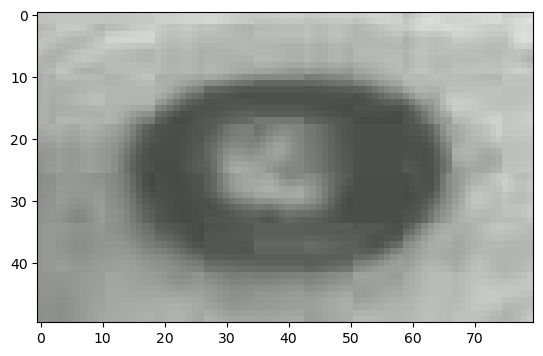

In [41]:
#preview the cropped video
capture.set(cv.CAP_PROP_POS_FRAMES, 1)

# Read and crop the first frame again
ret, frame = capture.read()
if ret:
    cropped_frame = frame[y_cord:y_cord+50, x_cord:x_cord+80] ########
    plt.imshow(cropped_frame)
    

In [23]:
from tqdm import tqdm
mseval = np.zeros(num_frames - 1)  # Preallocate array


ret, prev_frame = capture.read()
prev_frame = prev_frame[y_cord:y_cord+50, x_cord:x_cord+70]
prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY).astype(np.float32)

for i in tqdm(range(1, num_frames)):
    ret, curr_frame = capture.read()
    if not ret:
        break
        
    curr_frame = curr_frame[y_cord:y_cord+50, x_cord:x_cord+70]
    curr_gray = cv.cvtColor(curr_frame, cv.COLOR_BGR2GRAY).astype(np.float32)

    diff = curr_gray - prev_gray
    mse = np.mean(diff ** 2)
    mseval[i-1] = mse 
    
    prev_gray = curr_gray.copy()

100%|█████████████████████████████████████████████████████████████████████████▉| 97997/97999 [00:43<00:00, 2263.67it/s]


Text(0.5, 0, 'Frames')

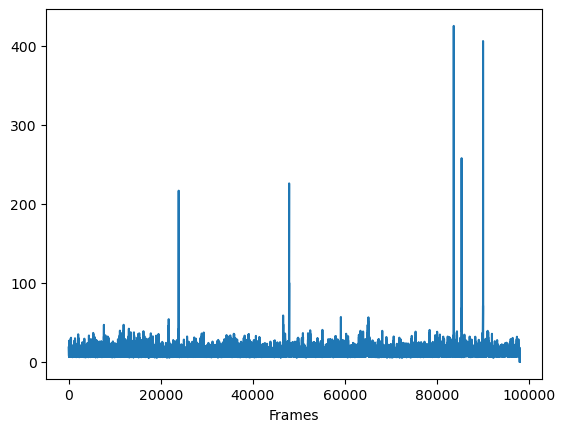

In [24]:
plt.plot(mseval)
plt.xlabel("Frames")

C:\Users\kangy\AppData\Local\Temp\ipykernel_14284\2437434700.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mseval, shade=True,color='crimson', label='KDE')


<Axes: ylabel='Density'>

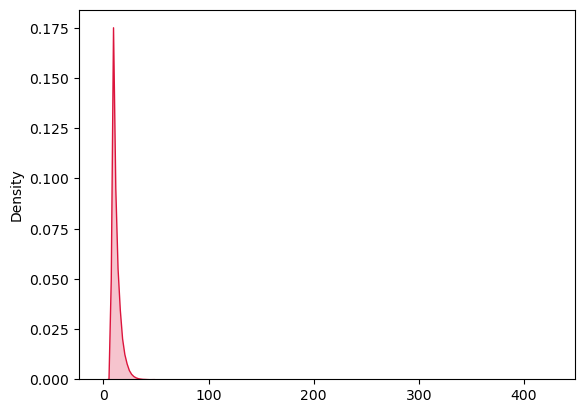

In [25]:
sns.kdeplot(mseval, shade=True,color='crimson', label='KDE')

In [26]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 2)
mseval = np.array(mseval)
gmm.fit(mseval.reshape(-1, 1))

x = np.linspace(0, np.ceil(np.max(mseval)), 10000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

#### peak
peaks, _ = find_peaks(y)  # Adjust `prominence` as needed
peak1, peak2 = x[peaks[0]], x[peaks[1]]  # Two largest peaks

# Get the values between the two peaks and find the minimum
valid_indices = [i for i in range(x.shape[0]) if i > peaks[0] and i < peaks[1]]
minimum = x[valid_indices[np.argmin(y[valid_indices])]]

plt.axvline(minimum, color='black', linestyle='--', 
            label='Inflection')
plt.plot(x, y)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [42]:
res = list(range(0, num_frames))

In [43]:
frames = load_significant_frames(avi, res)

100%|███████████████████████████████████████████████████████████████████████████| 98000/98000 [02:07<00:00, 770.08it/s]


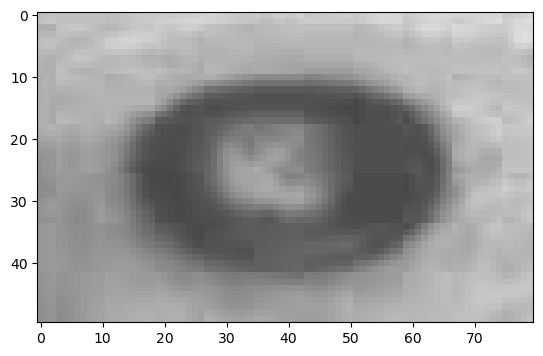

In [44]:
plt.imshow(frames[0])

In [45]:
horizontal_motion = []
prev_gray = cv.cvtColor(frames[0], cv.COLOR_BGR2GRAY)

for frame in tqdm(frames[1:], desc="Analyzing Motion"):
    curr_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Calculate dense optical flow
    flow = cv.calcOpticalFlowFarneback(
        prev_gray, curr_gray, 
        None, 0.5, 3, 15, 3, 5, 1.2, 0
    )
    
    # Focus on vertical motion (y-axis component)
    horizontal_flow = flow[..., 0]
    avg_horizontal = np.mean(horizontal_flow)
    horizontal_motion.append(avg_horizontal)
    
    prev_gray = curr_gray
horizontal_motion = np.array(horizontal_motion)

Analyzing Motion: 100%|█████████████████████████████████████████████████████████| 97999/97999 [01:56<00:00, 841.21it/s]


Text(0.5, 0, 'selected motion frames')

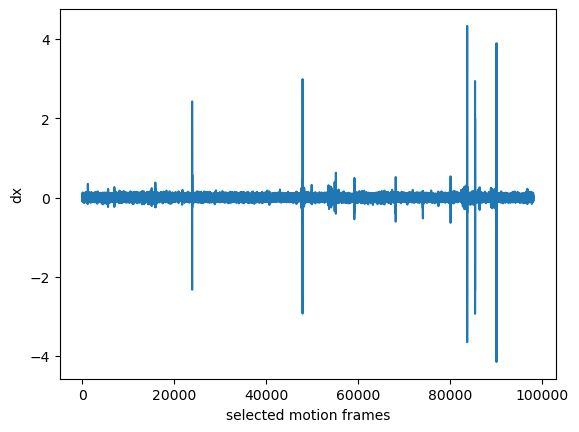

In [46]:
plt.plot(horizontal_motion)
plt.ylabel("dx")
plt.xlabel("selected motion frames")

Text(0.5, 1.0, 'attempt to fit tri-model')

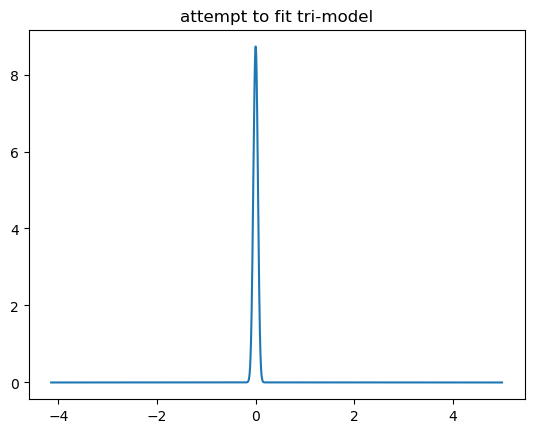

In [48]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 3)
gmm.fit(horizontal_motion.reshape(-1, 1))

x_1 = np.linspace(np.min(horizontal_motion), np.ceil(np.max(horizontal_motion)), 10000).reshape(-1, 1)
y_2 = np.exp(gmm.score_samples(x_1))

plt.plot(x_1, y_2)
plt.title("attempt to fit tri-model")

In [49]:
noise_level = noise_detection(
    horizontal_motion,
    noise_window=20,       # Larger for stable baselines
    min_duration=1,        # Minimum frames for valid peak
    prominence_factor=5  # Higher = fewer false positives
)

<Figure size 640x480 with 0 Axes>

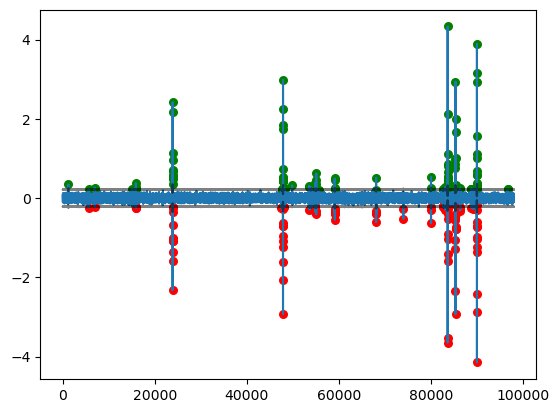

In [53]:
factor = 5
threshold = cfar_fast(horizontal_motion, num_guard_cells=1, num_ref_cells=15, bias=noise_level * factor)
right_peak_idxs = []
left_peak_idxs = []
for i, dx in enumerate(horizontal_motion):
    if dx > threshold[i]:
        right_peak_idxs.append(i)
    if dx < -threshold[i]:
        left_peak_idxs.append(i)
        
fig = plt.figure()
fig, ax = plt.subplots(1)
ax.plot(horizontal_motion)
ax.plot(abs(threshold), c="black", alpha=0.5)
ax.plot(-abs(threshold), c="black", alpha=0.5)
# Plot peaks
ax.scatter(right_peak_idxs, horizontal_motion[right_peak_idxs], c='green', s=30, label='Valid Right')
ax.scatter(left_peak_idxs, horizontal_motion[left_peak_idxs], c='red', s=30, label='Valid Left')

In [54]:
df_right = pd.DataFrame(
    {
        "res": right_peak_idxs,
        "ori": right_peak_idxs
    }
)

In [55]:
df_left = pd.DataFrame(
    {
        "res": left_peak_idxs,
        "ori": left_peak_idxs
    }
)

In [56]:
df_right["xsft"] = horizontal_motion[right_peak_idxs]
df_left["xsft"] = horizontal_motion[left_peak_idxs]

df_right["is_right"] = [1] * len(df_right)
df_left["is_right"] = [-1] * len(df_left)

In [58]:
combined_df = pd.concat([df_right, df_left], ignore_index=True)
combined_df

,res,ori,xsft,is_right
0,1205,1205,0.344220,1
1,5610,5610,0.216614,1
2,6935,6935,0.214000,1
3,6950,6950,0.261912,1
4,15080,15080,0.237559,1
...,...,...,...,...
224,90013,90013,-4.146945,-1
225,90016,90016,-2.414639,-1
226,90017,90017,-0.615315,-1
227,90020,90020,-1.026510,-1


In [61]:
def group_elements(combined_df, max_distance=200):
    sort_df = combined_df.sort_values(by="ori").reset_index()
    ori = sort_df["ori"].values
    res = sort_df["res"].values
    is_right = sort_df["is_right"].values
    
    groups = []
    current_ori_group = [ori[0]]  
    current_res_group = [res[0]]
    current_is_up_group = [is_right[0]]

    for i in range(1, len(ori)):
        if ori[i] - current_ori_group[-1] <= max_distance:
            current_ori_group.append(ori[i])
            current_res_group.append(res[i])
            current_is_up_group.append(is_right[i])
            
        else:
            df_group  = pd.DataFrame(
                {
                    "res" : current_res_group,
                    "ori" : current_ori_group,
                    "is_right": current_is_up_group
                }
            )
            
            groups.append(df_group)
            current_ori_group = [ori[i]]
            current_res_group = [res[i]]
            current_is_up_group = [is_right[i]]
    
    df_group  = pd.DataFrame(
                {
                    "res" : current_res_group,
                    "ori" : current_ori_group,
                    "is_right": current_is_up_group
                }
            )
            
    groups.append(df_group)
    
    return groups

In [62]:
grouped_array = group_elements(combined_df, max_distance=200)

In [66]:
import cv2
import numpy as np
import os

def create_clips(video_path, grouped_array, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Process each group
    for i, group in enumerate(grouped_array):
        # Calculate start and end frames with buffer
        ori = group["ori"].values
        res = group["res"].values
        is_right = group["is_right"].values
        
        group_start = max(0, ori[0] - 100)
        group_end = min(total_frames - 1, ori[-1] + 100)
        
        
        # Calculate original group bounds for text display
        original_start = ori[0]
        original_end = ori[-1]
        
        # Set up video writer with 0.5x speed (double the duration)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        output_path = os.path.join(output_folder, f'clip_{i+1}.mp4')
        out = cv2.VideoWriter(output_path, fourcc, fps * 0.2, (width, height))
        
        # Set text properties
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 3
        text_color = (255, 255, 255)  # White
        text_position = (45, 50)  # Top-Left corner
        
        # Seek to start frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, group_start)
        
        # Process frames in this group
        for frame_num in range(group_start, group_end + 1):
            ret, frame = cap.read()
            if not ret:
                break
                
            # Add "episode" text if within original group bounds
            if frame_num in ori:
                if (is_right[ori == frame_num][0] > 0):
                    cv2.putText(frame, 'right', text_position, 
                               font, font_scale, (255,0,0), font_thickness)
                elif (is_right[ori == frame_num][0] < 1):
                    cv2.putText(frame, 'left', text_position, 
                               font, font_scale, (0,0,255), font_thickness)
                
            
            # Write frame to output video
            out.write(frame)
        
        # Release current video writer
        out.release()
        print(f'Created clip {i+1} ({group_start}-{group_end} frames)')
    
    # Release video capture
    cap.release()
    print("All clips created successfully!")

In [67]:
video_path = avi
output_folder = f"{save_dir}/clips_f_{factor:0.0f}/"

create_clips(video_path, grouped_array, output_folder)

Created clip 1 (1105-1305 frames)
Created clip 2 (5495-5710 frames)
Created clip 3 (6835-7062 frames)
Created clip 4 (14980-15180 frames)
Created clip 5 (15756-15988 frames)
Created clip 6 (23754-23982 frames)
Created clip 7 (47438-47670 frames)
Created clip 8 (47755-47982 frames)
Created clip 9 (48060-48305 frames)
Created clip 10 (49742-49942 frames)
Created clip 11 (53404-53721 frames)
Created clip 12 (53779-54220 frames)
Created clip 13 (54732-54944 frames)
Created clip 14 (54995-55210 frames)
Created clip 15 (55601-55801 frames)
Created clip 16 (59004-59233 frames)
Created clip 17 (67996-68223 frames)
Created clip 18 (73899-74114 frames)
Created clip 19 (79920-80139 frames)
Created clip 20 (82604-82838 frames)
Created clip 21 (82961-83174 frames)
Created clip 22 (83241-83765 frames)
Created clip 23 (85242-85471 frames)
Created clip 24 (86013-86213 frames)
Created clip 25 (86242-86461 frames)
Created clip 26 (88706-88920 frames)
Created clip 27 (88971-89184 frames)
Created clip 28 